In [11]:
%matplotlib widget

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from matplotlib import cm

In [13]:
class Model():
    def __init__(self):
        self.delta = []
        self.delta_p = []
        self.cards = [1,2,3,4,5,6,7,8,9,10]
        
        # Set of state
        self.set_of_states = {
            "dealer_showing": (1,10),
            "player_sum": (12,21),
            "usable_ace": (0,1),
        }
        # Value function
        self.V = np.zeros((   
            self.set_of_states["dealer_showing"][1]-self.set_of_states["dealer_showing"][0]+1,
            self.set_of_states["player_sum"][1]-self.set_of_states["player_sum"][0]+1,
            self.set_of_states["usable_ace"][1]-self.set_of_states["usable_ace"][0]+1))
        
        # State-Action function
        self.Q = np.random.random((   
            self.set_of_states["dealer_showing"][1]-self.set_of_states["dealer_showing"][0]+1,
            self.set_of_states["player_sum"][1]-self.set_of_states["player_sum"][0]+1,
            self.set_of_states["usable_ace"][1]-self.set_of_states["usable_ace"][0]+1,
            2
        ))+2
        
        self.policy = np.random.choice([0,1],(   
            self.set_of_states["dealer_showing"][1]-self.set_of_states["dealer_showing"][0]+1,
            self.set_of_states["player_sum"][1]-self.set_of_states["player_sum"][0]+1,
            self.set_of_states["usable_ace"][1]-self.set_of_states["usable_ace"][0]+1))
        #self.policy[:,-2:,:] = 1
        self.N = np.zeros(self.Q.shape)
        
        self.gamma = 1
        
        self.NV = np.zeros(self.V.shape)
        
        
        
        
    def iterate_policy(self, episodes):
        
        for i in range(episodes):
            Q_bkup = self.Q.copy()
            P_bkup = self.policy.copy()
            
            dfc = np.random.choice(self.cards)
            state_0 = (dfc, 11 + np.random.choice(self.cards), np.random.choice(2))
            action_0 = np.random.choice(2)
            
            states, rewards, actions = self.generate_episode(initial_action=action_0,initial_state=state_0)
            
            
            G = 0
            for t in range(0,len(states))[::-1]:
                G = self.gamma * G + rewards[t]
                
                #print(f"G:{G}")
                case_pos = (states[t][0]-self.set_of_states["dealer_showing"][0],states[t][1]-self.set_of_states["player_sum"][0],states[t][2]-self.set_of_states["usable_ace"][0])
                
                self.N[case_pos[0]][case_pos[1]][case_pos[2]][int(actions[t])] += 1
                self.Q[case_pos[0]][case_pos[1]][case_pos[2]][int(actions[t])] += (G-self.Q[case_pos[0]][case_pos[1]][case_pos[2]][int(actions[t])]) /self.N[case_pos[0]][case_pos[1]][case_pos[2]][int(actions[t])]
                self.policy = np.argmax(self.Q,axis=-1)
                
                
            self.delta.append(np.sum(np.abs(Q_bkup-self.Q)))
            self.delta_p.append(np.sum(np.abs(P_bkup-self.policy)))
            
    
    def aproximateV(self,episodes):
        for i in tqdm(range(episodes)):
            states, rewards, actions = self.generate_episode()
            G = 0
            for t in range(0,len(states))[::-1]:
                
                G = self.gamma * G + rewards[t]
                #print(states[t])
                case_pos = (states[t][0]-self.set_of_states["dealer_showing"][0],states[t][1]-self.set_of_states["player_sum"][0],states[t][2]-self.set_of_states["usable_ace"][0])
                
                self.NV[case_pos[0]][case_pos[1]][case_pos[2]] += 1
                self.V[case_pos[0]][case_pos[1]][case_pos[2]] += (G-self.V[case_pos[0]][case_pos[1]][case_pos[2]]) /self.NV[case_pos[0]][case_pos[1]][case_pos[2]]
                
            
            
    def generate_episode(self, initial_action = None, initial_state = None):
        
        if initial_state == None:
            dfc = np.random.choice(self.cards)
            state = (dfc, 11 + np.random.choice(self.cards), 1)
        else:
            state = initial_state
            
        dealer_sum = state[0] + np.random.choice(self.cards)
            
        states = []
        rewards = []
        actions = []
        
        while True:
            states.append(state)
            state,r,dealer_sum,a = self.transition_model(state, dealer_sum,action = initial_action)
            initial_action = None
            
            actions.append(a)
            rewards.append(r)
            
            
            if state[0] == -1:
                break
                
        return states, rewards, actions
                
                
    def transition_model(self, state, dealer_sum, action = None):
        
        #Player move
        reward = 0
        
        if action == None:
            action = self.policy[state[0]-self.set_of_states["dealer_showing"][0],state[1]-self.set_of_states["player_sum"][0],state[2]-self.set_of_states["usable_ace"][0]]
        
        #print(f"Action:{action}")
        
        if action == 0: #take   
            
            player_sum = state[1] + np.random.choice(self.cards)
            
            if player_sum > 21 and state[2] == 1:
                player_sum -= 10
                next_state = (state[0],player_sum,0)
            elif  player_sum <= 21:
                next_state = (state[0],player_sum,state[2])
            else:
                #player loses
                next_state = (-1,player_sum,-1)
                reward = -1
                #print(f"Player bust")
                return(next_state, reward, dealer_sum,action)
            
        else:
            player_sum = state[1]
            next_state = state
            
        # Dealer move
        if dealer_sum < 17:
            dealer_sum += np.random.choice(self.cards)
            if dealer_sum > 21:
                next_state = (-1,player_sum,-1)
                
                #print(f"Dealer bust")
                reward = 1
        
        if  self.policy[state[0]-self.set_of_states["dealer_showing"][0],state[1]-self.set_of_states["player_sum"][0],state[2]-self.set_of_states["usable_ace"][0]] == 1 and dealer_sum <= 21: #End game
            
            #print(f"No more moves")
            if dealer_sum > player_sum:
                reward = -1
            elif dealer_sum == player_sum:
                reward = 0
            else:
                reward = 1
            next_state = (-1,player_sum,-1)
        return(next_state, reward, dealer_sum,action)
    



In [14]:
m = Model()
ps = []
m.iterate_policy(100000)
a = 400
for i in tqdm(range(a)):
    m.iterate_policy(100)
    ps.append(m.policy)

pol = np.sum(ps,axis=0)/a
pold = pol.copy()
pold[pold>.5] = 1
pold[pold<=.5] = 0
#pol[:,:,0]

  0%|          | 0/400 [00:00<?, ?it/s]

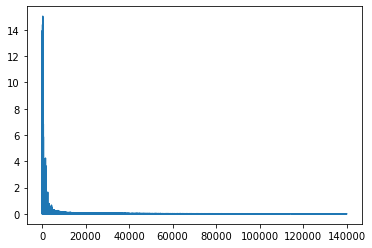

In [5]:
plt.plot(list(range(len(m.delta))),m.delta)
plt.show()

In [15]:

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(5, 5)
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Make data.
X = np.arange(12,22)
Y = np.arange(1,11)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, pol[:,:,0], linewidth=0, antialiased=False,cmap=cm.plasma)

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(X, Y, pol[:,:,1], linewidth=0, antialiased=False,cmap=cm.plasma)
"""

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(pol[:,:,0],cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(pol[:,:,1],cmap="gray")
"""
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
m.policy = pold

In [17]:
m.aproximateV(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(10, 5)

# Make data.
X = np.arange(12,22)
Y = np.arange(1,11)
X, Y = np.meshgrid(X, Y)


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, m.V[:,:,0], linewidth=0, antialiased=False,cmap=cm.plasma)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, m.V[:,:,1], linewidth=0, antialiased=False,cmap=cm.plasma)


plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …